## 1. Setup
Install dependencies and clone TensorFlow Object Detection API

In [1]:
!pip install tensorflow==1.15

     |████████████████████████████████| 412.3MB 33kB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 3.8MB 33.7MB/s 
     |████████████████████████████████| 512kB 39.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=a5e751282a12815a8ae2e7173645237de45f3dad5d26a8f4bea771c4e1ab4bd0
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.15.0 which is incompatible.
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installati

In [2]:
!pip install ensemble-boxes==1.0.6

In [3]:
!pip install -U tf2onnx==1.8.5

     |████████████████████████████████| 378kB 7.5MB/s 
     |████████████████████████████████| 12.2MB 9.1MB/s 


In [4]:
!pip install -U tf2onnx

Requirement already up-to-date: tf2onnx in /usr/local/lib/python3.7/dist-packages (1.8.5)


In [5]:
!pip install nnoir-onnx==1.0.11

     |████████████████████████████████| 4.1MB 11.1MB/s 


In [6]:
!wget https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt
!wget http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz -P /content/
!tar xfz /content/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz

--2021-05-27 13:40:08--  https://raw.githubusercontent.com/amikelive/coco-labels/master/coco-labels-paper.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702 [text/plain]
Saving to: ‘coco-labels-paper.txt’

coco-labels-paper.t 100%[===================>]     702  --.-KB/s    in 0s      

2021-05-27 13:40:08 (22.4 MB/s) - ‘coco-labels-paper.txt’ saved [702/702]

--2021-05-27 13:40:08--  http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.137.128, 2607:f8b0:4023:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.137.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51025348 (49M) [applica

In [7]:
!git clone https://github.com/tensorflow/models.git
%cd models/
!git checkout 0ea84d6df6220552cd5229a0181c9e420f815408

Cloning into 'models'...
remote: Enumerating objects: 57460, done.
remote: Counting objects: 100% (1523/1523), done.
remote: Compressing objects: 100% (597/597), done.
remote: Total 57460 (delta 1040), reused 1362 (delta 910), pack-reused 55937
Receiving objects: 100% (57460/57460), 572.92 MiB | 30.78 MiB/s, done.
Resolving deltas: 100% (39702/39702), done.
/content/models
Note: checking out '0ea84d6df6220552cd5229a0181c9e420f815408'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 0ea84d6d Changing the default number of channels for lighter-weight hourglass backbones.


In [8]:
import os
import math
import subprocess
import onnx
import numpy as np
import tensorflow as tf
import cv2
import nnoir
from collections import namedtuple
from PIL import Image, ImageDraw, ImageFont
from ensemble_boxes import *

In [9]:
%cd /content/models/research 

/content/models/research


In [10]:
!apt --quiet update
!apt install --quiet protobuf-compiler

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [60.9 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/

In [11]:
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf1/setup.py .
!python3 -m pip install .

Processing /content/models/research
     |████████████████████████████████| 358kB 7.8MB/s 
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1628543 sha256=acae60d34c5255b0aaab6f6d21266b393d70680cc56a7751296851c2fdc9315b
  Stored in directory: /tmp/pip-ephem-wheel-cache-qev7j80p/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection


In [12]:
!python3 object_detection/builders/model_builder_tf1_test.py

Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[       OK ] ModelBuilderTF1Test.test_create_context_rcnn_from_config_with_params1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_experimental_model
[       OK ] ModelBuilderTF1Test.test_create_experimental_model
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature0 (True)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[       OK ] ModelBuilderTF1Test.test_create_faster_rcnn_from_config_with_crop_feature1 (False)
[ RUN      ] ModelBuilderTF1Test.test_create_faster_rcnn_model_from_config_w

## 2. Create TensorFlow Lite Model
set add_postprocessing_op=False

In [13]:
!python /content/models/research/object_detection/export_tflite_ssd_graph.py \
--pipeline_config_path=/content/ssdlite_mobilenet_v2_coco_2018_05_09/pipeline.config \
--trained_checkpoint_prefix=/content/ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt \
--output_directory=/content \
--add_postprocessing_op=False

Instructions for updating:
Please use `layer.__call__` method instead.
W0527 13:40:58.015194 139856932210560 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0527 13:41:00.569398 139856932210560 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0527 13:41:00.660439 139856932210560 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0527 13:41:00.760516 139856932210560 convolutional_box_predictor.py:156] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv befo

In [14]:
!tflite_convert \
--graph_def_file=/content/tflite_graph.pb \
--output_file=/content/ssdlite_mobilenet_v2.tflite \
--input_format=TENSORFLOW_GRAPHDEF \
--output_format=TFLITE \
--inference_type=FLOAT \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays=raw_outputs/box_encodings,raw_outputs/class_predictions

2021-05-27 13:41:06.610434: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-05-27 13:41:06.620103: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-05-27 13:41:06.620157: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (b9f0577c57d4): /proc/driver/nvidia/version does not exist
2021-05-27 13:41:06.620513: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2021-05-27 13:41:06.625631: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 1999995000 Hz
2021-05-27 13:41:06.625930: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55a08ad96a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021

## 3. Create anchor 

In [15]:
from tensorflow.python.platform import gfile
from tensorflow.python.framework import tensor_util

GRAPH_PB_PATH = '/content/tflite_graph.pb'

with tf.Session() as sess:
  with gfile.FastGFile(GRAPH_PB_PATH,'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    graph_nodes=[n for n in graph_def.node]
    wts = [n for n in graph_nodes if n.op=='Const']
    for n in wts:
        if n.name == 'anchors':
            print("Name of the node - %s" % n.name)
            print("Value - ")
            anchors = tensor_util.MakeNdarray(n.attr['value'].tensor)
            print("anchors.shape =", anchors.shape)
            print(anchors)
            np.save('/content/anchors.npy', anchors)
            np.savetxt('/content/anchors.csv', anchors, delimiter=',')
            break

Instructions for updating:
Use tf.gfile.GFile.
Name of the node - anchors
Value - 
anchors.shape = (1917, 4)
[[0.02631579 0.02631579 0.1        0.1       ]
 [0.02631579 0.02631579 0.14142136 0.28284273]
 [0.02631579 0.02631579 0.28284273 0.14142136]
 ...
 [0.5        0.5        0.5484828  1.6454482 ]
 [0.5        0.5        1.6455305  0.54845536]
 [0.5        0.5        0.97467947 0.97467947]]


https://github.com/ChrystleMyrnaLobo/tflite-object-detection/blob/master/inference.py

## 4. Convert TensorFlow Lite Model to ONNX

In [16]:
!python -m tf2onnx.convert --tflite /content/ssdlite_mobilenet_v2.tflite \
--output /content/ssdlite_mobilenet_v2.onnx --opset 13

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))

2021-05-27 13:41:12,393 - WARNING - From /usr/local/lib/python3.7/dist-packages/tf2onnx/verbose_logging.py:76: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2021-05-27 13:41:12,395 - INFO - Using tensorflow=1.15.0, onnx=1.9.0, tf2onnx=1.8.5/50049d
2021-05-27 13:41:12,395 - INFO - Using opset <onnx, 13>
2021-05-27 13:41:12,858 - INFO - Optimizing ONNX model
2021-05-27 13:41:14,420 - INFO - After optimization: Cast -13 (13->0), Const -159 (340->181), Identity -2 (2->0), Reshape -33 (46->13), Transpose -341 (352->11)
2021-05-27 13:41:14,463 - INFO - 
2021-05-27 13:41:14,463 - INFO - Successfully converted TensorFlow model /content/ssdlite_mobilenet_v2.tflite to ONNX
2021-05-27 13:41:14,463 - INF

In [17]:
onnx_model = onnx.load("/content/ssdlite_mobilenet_v2.onnx")
try:
    onnx.checker.check_model(onnx_model)
except onnx.checker.ValidationError as e:
    print('The model is invalid: %s' % e)
else:
    print('The model is valid.')

The model is valid.


In [18]:
onnx_model_output =[node.name for node in onnx_model.graph.output]
print(onnx_model_output)

['raw_outputs/box_encodings', 'raw_outputs/class_predictions']


In [19]:
input_all = [node.name for node in onnx_model.graph.input]
input_initializer =  [node.name for node in onnx_model.graph.initializer]
net_feed_input = list(set(input_all)  - set(input_initializer))

print(net_feed_input)

['normalized_input_image_tensor']


## 5. Convert ONNX Model to nnoir

In [20]:
!onnx2nnoir -o /content/tf1_ssdlite_mobilenet_v2.nnoir /content/ssdlite_mobilenet_v2.onnx

In [21]:
nnoir_model = nnoir.load('/content/tf1_ssdlite_mobilenet_v2.nnoir')

In [22]:
image = cv2.imread("/content/models/research/object_detection/test_images/image1.jpg")
image = cv2.resize(image, (300, 300))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_expanded = np.expand_dims(image_rgb.astype(np.float32), axis=0)
image_normalized =  (np.float32(image_expanded) - 127.5) / 127.5

## 6. nnoir Inference

In [23]:
box_encodings, class_predictions = nnoir_model.run(image_normalized)

In [24]:
print(box_encodings)

[[[ 1.2543372   0.05279279 -0.17924239 -3.7939389 ]
  [ 1.3623079   1.2352078  -0.89161694 -1.9596071 ]
  [ 1.2096498   0.88237387 -1.4187534  -1.591444  ]
  ...
  [ 0.03302317  0.02136471  0.79330087 -2.520231  ]
  [-0.00524751  0.534054   -2.648937    0.53653073]
  [-0.03221654  1.6893749  -0.31980103 -2.2999258 ]]]


In [25]:
print(class_predictions)

[[[9.35962915e-01 1.63256228e-02 3.05622816e-04 ... 3.24475765e-03
   2.34842300e-05 5.59389591e-05]
  [9.67375040e-01 5.67057729e-03 2.15053558e-04 ... 1.06680393e-03
   2.81035900e-05 5.07533550e-05]
  [9.59834576e-01 5.90893626e-03 1.28507614e-04 ... 1.01625919e-03
   1.18017197e-05 1.37090683e-05]
  ...
  [9.81339812e-01 1.19566917e-03 3.36766243e-04 ... 2.61098146e-04
   1.21086836e-04 7.96318054e-05]
  [9.78530407e-01 1.95056200e-03 3.80486250e-04 ... 1.81853771e-04
   1.21057034e-04 4.79817390e-05]
  [2.41788298e-01 6.10494614e-03 3.06546688e-04 ... 4.55796719e-04
   1.91330910e-05 2.08616257e-06]]]


In [26]:
labels = np.array([], dtype=int)
result_labels = np.append(labels, np.argmax(class_predictions[0], axis=1))

In [27]:
# Get Indexes that predict something other than background.
indexes_not_background = np.where(result_labels!=0)

In [28]:
labels_not_background = np.take(result_labels, indexes_not_background)

In [29]:
scores = []
scores.append(list(map(max, class_predictions[0])))
scores_not_background = np.take(scores[0], indexes_not_background)

In [30]:
# from pipeline.config
y_scale = 10.0
x_scale = 10.0
h_scale = 5.0
w_scale = 5.0

def decode_box_encodings(box_encoding, anchors, num_boxes):
    decoded_boxes = np.zeros((num_boxes, 4), dtype=np.float32)
    for i in range(num_boxes):
        ycenter = box_encoding[i][0] / y_scale * anchors[i][2] + anchors[i][0]
        xcenter = box_encoding[i][1] / x_scale * anchors[i][3] + anchors[i][1]
        half_h = 0.5 * math.exp((box_encoding[i][2] / h_scale)) * anchors[i][2]
        half_w = 0.5 * math.exp((box_encoding[i][3] / w_scale)) * anchors[i][3]
        decoded_boxes[i][0] = (xcenter - half_w) # xmin 
        decoded_boxes[i][1] = (ycenter - half_h) # ymin
        decoded_boxes[i][2] = (xcenter + half_w) # xmax
        decoded_boxes[i][3] = (ycenter + half_h) # ymax
    return decoded_boxes

In [31]:
anchors = np.load('/content/anchors.npy')
box_decoded = decode_box_encodings(box_encodings[0], anchors, 1917)
box_not_background = np.take(box_decoded, indexes_not_background, axis=0)
box_clipped = box_not_background.clip(0, 1)

In [32]:
nms_boxes, nms_scores, nms_labels = nms(box_clipped.tolist(), scores_not_background.tolist(), labels_not_background.tolist(), iou_thr=0.5)

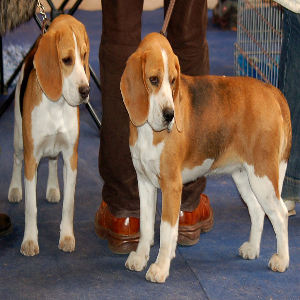

In [33]:
image_pil = Image.fromarray(image_rgb)
image_pil

In [34]:
coco_labels = ['background']
with open("/content/coco-labels-paper.txt",'r') as f:
  for line in f:
    coco_labels.append(line.rstrip())

In [35]:
coco_labels_length = len(coco_labels)
draw = ImageDraw.Draw(image_pil)
for box, scores, label in zip(nms_boxes, nms_scores, nms_labels):
  if label > 0 and label < coco_labels_length:
    xmin = box[0]*300
    ymin = box[1]*300
    xmax = box[2]*300
    ymax = box[3]*300
    draw.rectangle((xmin, ymin, xmax, ymax), outline=(0, 0, 255), width=2)
    draw.text([xmin+2, ymin+2], text=coco_labels[label])

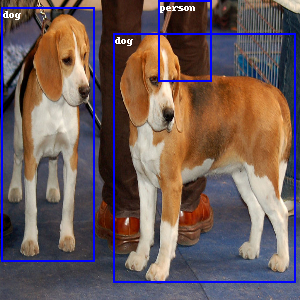

In [36]:
image_pil